In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_csv('Data Analyst Test Task Data - Tasks 1-2.csv')


In [5]:
df.head()

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id
0,0001feb9-ec8e-4f53-83c8-a829bbbe1838,2023-05-18 22:16:16,trial,weekly.2.49,False,7,0,0.00,e99b4003-7bb9-4cbe-a585-e8a103b0e3cb,NaN
1,0001feb9-ec8e-4f53-83c8-a829bbbe1838,2023-05-18 22:25:56,cancellation,weekly.2.49,False,7,0,0.00,dc4e828a-f365-46e4-90ef-bb2785379d1a,NaN
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-05-30 7:10:37,trial,weekly.2.49,False,7,0,0.00,b585adc7-f22a-4cd4-b863-2eb256d697b4,NaN
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36005 entries, 0 to 36004
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uuid                     36005 non-null  object 
 1   event_timestamp          36005 non-null  object 
 2   event_name               36005 non-null  object 
 3   product_id               36005 non-null  object 
 4   is_trial                 36005 non-null  bool   
 5   period                   36005 non-null  int64  
 6   trial_period             36005 non-null  int64  
 7   revenue_usd              36005 non-null  float64
 8   transaction_id           36005 non-null  object 
 9   refunded_transaction_id  202 non-null    object 
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 2.5+ MB


In [7]:
df.describe()

,period,trial_period,revenue_usd
count,36005.000000,36005.000000,36005.000000
mean,13.152923,1.503541,2.171181
std,10.181436,1.500017,3.140630
min,7.000000,0.000000,-9.990000
25%,7.000000,0.000000,0.000000
50%,7.000000,3.000000,0.000000
75%,30.000000,3.000000,4.990000
max,30.000000,3.000000,9.990000


In [8]:
distinct_dates = df['event_timestamp'].unique()
distinct_dates

array(['2023-05-18 22:16:16', '2023-05-18 22:25:56', '2023-05-30 7:10:37',
       ..., '2023-03-04 16:41:31', '2023-05-09 0:25:58',
       '2023-05-09 0:27:46'], dtype=object)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], format='%Y-%m-%d %H:%M:%S')

#filter only purchase events 
df_purchase = df[df['event_name'] == 'purchase'].copy()

#get first purchase month
df_purchase['event_month'] = df_purchase['event_timestamp'].dt.to_period('M')
first_purchase = df_purchase.groupby('uuid')['event_month'].min().reset_index()
first_purchase.columns = ['uuid', 'first_purchase_month']
first_purchase

,uuid,first_purchase_month
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06
1,0015b6c7-85fb-4c36-9dfb-4ff348c39906,2023-05
2,002d7b10-b35f-4cb4-a345-297f53eaf85e,2023-03
3,002efdd9-47cd-4454-85d5-47d1ad1202b2,2023-03
4,0047993c-3cff-4ab4-a34a-e376f823c282,2023-03
...,...,...
2376,ff4f6ada-2f5d-4273-a5ec-0f4d8c40ad02,2023-05
2377,ff963f4e-b13e-4a4a-a805-201f56cd4d11,2023-05
2378,ff9a70ec-9962-4378-9fab-011780499257,2023-03
2379,ff9c10a1-7510-43e4-873c-9365beffec86,2023-04


In [11]:
#merge the first purchase month with rest of data
df_purchase = df_purchase.merge(first_purchase, on='uuid', how='left')
df_purchase

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,event_month,first_purchase_month
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN,2023-06,2023-06
1,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN,2023-06,2023-06
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-20 23:10:53,purchase,weekly.2.49,False,7,0,2.49,b0e50445-f8bb-4677-86c9-e34f49a274ab,NaN,2023-06,2023-06
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-27 23:10:46,purchase,weekly.2.49,False,7,0,2.49,4e9a3204-f64c-4e7f-b2ec-ebbbb813b142,NaN,2023-06,2023-06
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-07-04 23:10:37,purchase,weekly.2.49,False,7,0,2.49,be75126f-e581-49fc-a84c-8ed682c8d4ca,NaN,2023-07,2023-06
...,...,...,...,...,...,...,...,...,...,...,...,...
15749,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-02 15:20:16,purchase,weekly.2.49,False,7,0,2.49,3112b581-d57e-4eb8-ba03-f46d9b2c7ecf,NaN,2023-09,2023-03
15750,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-08 15:20:21,purchase,weekly.2.49,False,7,0,2.49,328c1907-c025-4525-9b58-c69f71bd80b4,NaN,2023-09,2023-03
15751,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-15 15:20:23,purchase,weekly.2.49,False,7,0,2.49,1dc95ec4-4719-4258-949a-4c64dfbd9773,NaN,2023-09,2023-03
15752,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-23 15:20:07,purchase,weekly.2.49,False,7,0,2.49,f93422d3-e8fa-4eab-a9b0-ecccc63769b4,NaN,2023-09,2023-03


In [12]:

df_filtered = df_purchase[df_purchase['first_purchase_month'].notna()]

df_filtered

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,event_month,first_purchase_month
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN,2023-06,2023-06
1,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN,2023-06,2023-06
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-20 23:10:53,purchase,weekly.2.49,False,7,0,2.49,b0e50445-f8bb-4677-86c9-e34f49a274ab,NaN,2023-06,2023-06
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-27 23:10:46,purchase,weekly.2.49,False,7,0,2.49,4e9a3204-f64c-4e7f-b2ec-ebbbb813b142,NaN,2023-06,2023-06
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-07-04 23:10:37,purchase,weekly.2.49,False,7,0,2.49,be75126f-e581-49fc-a84c-8ed682c8d4ca,NaN,2023-07,2023-06
...,...,...,...,...,...,...,...,...,...,...,...,...
15749,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-02 15:20:16,purchase,weekly.2.49,False,7,0,2.49,3112b581-d57e-4eb8-ba03-f46d9b2c7ecf,NaN,2023-09,2023-03
15750,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-08 15:20:21,purchase,weekly.2.49,False,7,0,2.49,328c1907-c025-4525-9b58-c69f71bd80b4,NaN,2023-09,2023-03
15751,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-15 15:20:23,purchase,weekly.2.49,False,7,0,2.49,1dc95ec4-4719-4258-949a-4c64dfbd9773,NaN,2023-09,2023-03
15752,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-23 15:20:07,purchase,weekly.2.49,False,7,0,2.49,f93422d3-e8fa-4eab-a9b0-ecccc63769b4,NaN,2023-09,2023-03


In [13]:
#get the event month from date
df_filtered['event_month'] = df_filtered['event_timestamp'].dt.to_period('M')

#calculate the cohort lifetime
df_filtered['cohort_lifetime'] = (df_filtered['event_month'].dt.to_timestamp() - df_filtered['first_purchase_month'].dt.to_timestamp()).dt.days // 30
df_filtered

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,event_month,first_purchase_month,cohort_lifetime
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN,2023-06,2023-06,0
1,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN,2023-06,2023-06,0
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-20 23:10:53,purchase,weekly.2.49,False,7,0,2.49,b0e50445-f8bb-4677-86c9-e34f49a274ab,NaN,2023-06,2023-06,0
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-27 23:10:46,purchase,weekly.2.49,False,7,0,2.49,4e9a3204-f64c-4e7f-b2ec-ebbbb813b142,NaN,2023-06,2023-06,0
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-07-04 23:10:37,purchase,weekly.2.49,False,7,0,2.49,be75126f-e581-49fc-a84c-8ed682c8d4ca,NaN,2023-07,2023-06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15749,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-02 15:20:16,purchase,weekly.2.49,False,7,0,2.49,3112b581-d57e-4eb8-ba03-f46d9b2c7ecf,NaN,2023-09,2023-03,6
15750,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-08 15:20:21,purchase,weekly.2.49,False,7,0,2.49,328c1907-c025-4525-9b58-c69f71bd80b4,NaN,2023-09,2023-03,6
15751,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-15 15:20:23,purchase,weekly.2.49,False,7,0,2.49,1dc95ec4-4719-4258-949a-4c64dfbd9773,NaN,2023-09,2023-03,6
15752,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-23 15:20:07,purchase,weekly.2.49,False,7,0,2.49,f93422d3-e8fa-4eab-a9b0-ecccc63769b4,NaN,2023-09,2023-03,6


In [31]:
#create a pivot table to count unique users per cohort and cohort lifetime
cohorts = df_filtered.pivot_table(index=['first_purchase_month', 'cohort_lifetime'],
                          aggfunc={'uuid': 'nunique'}).reset_index()
cohorts




,first_purchase_month,cohort_lifetime,product_id,revenue_usd,uuid
0,2023-03,0,monthly.7.49,509.32000,68
1,2023-03,0,monthly.9.99.3d.trial,1274.13415,131
2,2023-03,0,weekly.2.49,1410.89846,308
3,2023-03,0,weekly.4.99.3d.trial,2324.36636,241
4,2023-03,1,monthly.7.49,591.31623,39
...,...,...,...,...,...
153,2023-10,0,monthly.7.49,7.49000,1
154,2023-10,0,monthly.9.99.3d.trial,59.94000,6
155,2023-10,0,weekly.2.49,2.49000,1
156,2023-10,0,weekly.4.99.3d.trial,14.97000,2


In [15]:
# get the initial number of users in each cohort
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]
initial_users_count = initial_users_count[['first_purchase_month', 'uuid']]
initial_users_count = initial_users_count.rename(columns={'uuid': 'cohort_users'})
initial_users_count

,first_purchase_month,cohort_users
0,2023-03,748
9,2023-04,527
17,2023-05,738
24,2023-06,247
30,2023-07,49
35,2023-08,40
39,2023-09,22
42,2023-10,10


In [16]:
#merge initial_users_count with the cohorts dataframe to get the number of initial customers in each cohort
cohorts = cohorts.merge(initial_users_count, on='first_purchase_month', how='left')
#find the percent of users that remained in each period of time from the initial number of customers in the cohort.
cohorts

,first_purchase_month,cohort_lifetime,uuid,cohort_users
0,2023-03,0,748,748
1,2023-03,1,393,748
2,2023-03,2,251,748
3,2023-03,3,189,748
4,2023-03,4,151,748
5,2023-03,5,113,748
6,2023-03,6,91,748
7,2023-03,7,68,748
8,2023-03,8,18,748
9,2023-04,0,527,527


In [18]:
#find the percent of users that remained in each period of time from the initial number of customers in the cohort.
cohorts['retention'] = cohorts['uuid'] / cohorts['cohort_users']

retention_cohorts = cohorts

retention_cohorts

,first_purchase_month,cohort_lifetime,uuid,cohort_users,retention
0,2023-03,0,748,748,1.000000
1,2023-03,1,393,748,0.525401
2,2023-03,2,251,748,0.335561
3,2023-03,3,189,748,0.252674
4,2023-03,4,151,748,0.201872
5,2023-03,5,113,748,0.151070
6,2023-03,6,91,748,0.121658
7,2023-03,7,68,748,0.090909
8,2023-03,8,18,748,0.024064
9,2023-04,0,527,527,1.000000


In [19]:
#Retention Rate for each cohort during its lifetime
retention_pivot = cohorts.pivot_table(index='first_purchase_month',
                                       columns='cohort_lifetime',
                                       values='retention',
                                       aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8
first_purchase_month,,,,,,,,,
2023-03,1.0,0.525401,0.335561,0.252674,0.201872,0.151070,0.121658,0.090909,0.024064
2023-04,1.0,0.565465,0.379507,0.250474,0.203036,0.151803,0.113852,0.034156,NaN
2023-05,1.0,0.512195,0.314363,0.220867,0.161247,0.119241,0.017615,NaN,NaN
2023-06,1.0,0.465587,0.307692,0.194332,0.141700,0.032389,NaN,NaN,NaN
2023-07,1.0,0.510204,0.265306,0.163265,0.040816,NaN,NaN,NaN,NaN
2023-08,1.0,0.525000,0.250000,0.025000,NaN,NaN,NaN,NaN,NaN
2023-09,1.0,0.363636,0.090909,NaN,NaN,NaN,NaN,NaN,NaN
2023-10,1.0,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


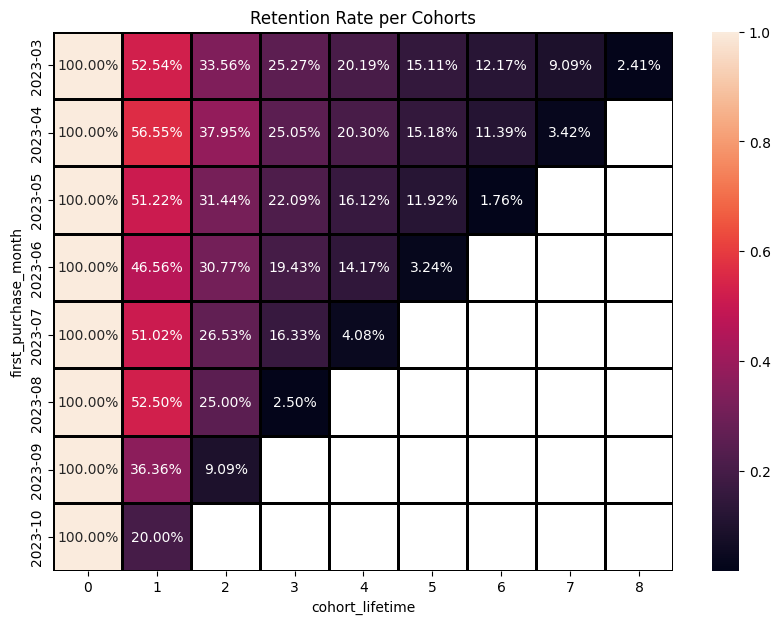

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot.iloc[:, 0:], annot=True, 
            fmt='.2%', linewidths=1, linecolor='black'); 

In [42]:
df_filtered

,uuid,event_timestamp,event_name,product_id,is_trial,period,trial_period,revenue_usd,transaction_id,refunded_transaction_id,event_month,first_purchase_month,cohort_lifetime
0,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-05 23:10:44,purchase,weekly.2.49,False,7,0,2.49,b672df8a-fcb2-4737-8a5f-98a85b183609,NaN,2023-06,2023-06,0
1,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-12 23:10:57,purchase,weekly.2.49,False,7,0,2.49,33254b74-1437-4eb1-a71d-be3c0958bdf8,NaN,2023-06,2023-06,0
2,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-20 23:10:53,purchase,weekly.2.49,False,7,0,2.49,b0e50445-f8bb-4677-86c9-e34f49a274ab,NaN,2023-06,2023-06,0
3,00026e14-e302-4772-b691-8b0e67ab0c32,2023-06-27 23:10:46,purchase,weekly.2.49,False,7,0,2.49,4e9a3204-f64c-4e7f-b2ec-ebbbb813b142,NaN,2023-06,2023-06,0
4,00026e14-e302-4772-b691-8b0e67ab0c32,2023-07-04 23:10:37,purchase,weekly.2.49,False,7,0,2.49,be75126f-e581-49fc-a84c-8ed682c8d4ca,NaN,2023-07,2023-06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15749,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-02 15:20:16,purchase,weekly.2.49,False,7,0,2.49,3112b581-d57e-4eb8-ba03-f46d9b2c7ecf,NaN,2023-09,2023-03,6
15750,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-08 15:20:21,purchase,weekly.2.49,False,7,0,2.49,328c1907-c025-4525-9b58-c69f71bd80b4,NaN,2023-09,2023-03,6
15751,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-15 15:20:23,purchase,weekly.2.49,False,7,0,2.49,1dc95ec4-4719-4258-949a-4c64dfbd9773,NaN,2023-09,2023-03,6
15752,ffd11729-f3b3-4993-acce-c41e4115df46,2023-09-23 15:20:07,purchase,weekly.2.49,False,7,0,2.49,f93422d3-e8fa-4eab-a9b0-ecccc63769b4,NaN,2023-09,2023-03,6


In [69]:
#counting revenue per cohort
revenue_cohorts = df_filtered.pivot_table(index=['first_purchase_month', 'cohort_lifetime'],
                                  aggfunc={'uuid': 'nunique', 'revenue_usd': 'sum'}).reset_index()

revenue_cohorts

,first_purchase_month,cohort_lifetime,revenue_usd,uuid
0,2023-03,0,5518.71897,748
1,2023-03,1,5770.62133,393
2,2023-03,2,5079.94875,251
3,2023-03,3,3742.91759,189
4,2023-03,4,2958.60991,151
5,2023-03,5,2153.61036,113
6,2023-03,6,1580.18703,91
7,2023-03,7,1095.17008,68
8,2023-03,8,206.80749,18
9,2023-04,0,3845.41779,527


In [79]:
#counting total revenue per cohort
cohorts_r = revenue_cohorts.groupby('first_purchase_month')['revenue_usd'].sum().reset_index()

cohorts_r.columns = ['first_purchase_month', 'total_revenue']

cohorts_r


,first_purchase_month,total_revenue
0,2023-03,28106.59151
1,2023-04,19812.60258
2,2023-05,22217.80238
3,2023-06,6790.24350
4,2023-07,1180.70051
5,2023-08,741.51939
6,2023-09,240.67771
7,2023-10,104.87000


In [71]:
#merge retention_cohorts and revenue_cohorts
cohorts_combined = retention_cohorts.merge(revenue_cohorts, 
                                             on=['first_purchase_month', 'cohort_lifetime', 'uuid'],
                                             how='left')

cohorts_combined


,first_purchase_month,cohort_lifetime,uuid,cohort_users,retention,revenue_usd
0,2023-03,0,748,748,1.000000,5518.71897
1,2023-03,1,393,748,0.525401,5770.62133
2,2023-03,2,251,748,0.335561,5079.94875
3,2023-03,3,189,748,0.252674,3742.91759
4,2023-03,4,151,748,0.201872,2958.60991
5,2023-03,5,113,748,0.151070,2153.61036
6,2023-03,6,91,748,0.121658,1580.18703
7,2023-03,7,68,748,0.090909,1095.17008
8,2023-03,8,18,748,0.024064,206.80749
9,2023-04,0,527,527,1.000000,3845.41779


In [72]:
#countng ltv
cohorts_combined['ltv'] = cohorts_combined['retention'] * cohorts_combined['revenue_usd']

ltv_results = cohorts_combined[['first_purchase_month', 'cohort_lifetime','uuid','retention', 'ltv']]
ltv_results

,first_purchase_month,cohort_lifetime,uuid,retention,ltv
0,2023-03,0,748,1.000000,5518.718970
1,2023-03,1,393,0.525401,3031.890619
2,2023-03,2,251,0.335561,1704.635209
3,2023-03,3,189,0.252674,945.737199
4,2023-03,4,151,0.201872,597.259487
5,2023-03,5,113,0.151070,325.344881
6,2023-03,6,91,0.121658,192.242005
7,2023-03,7,68,0.090909,99.560916
8,2023-03,8,18,0.024064,4.976651
9,2023-04,0,527,1.000000,3845.417790


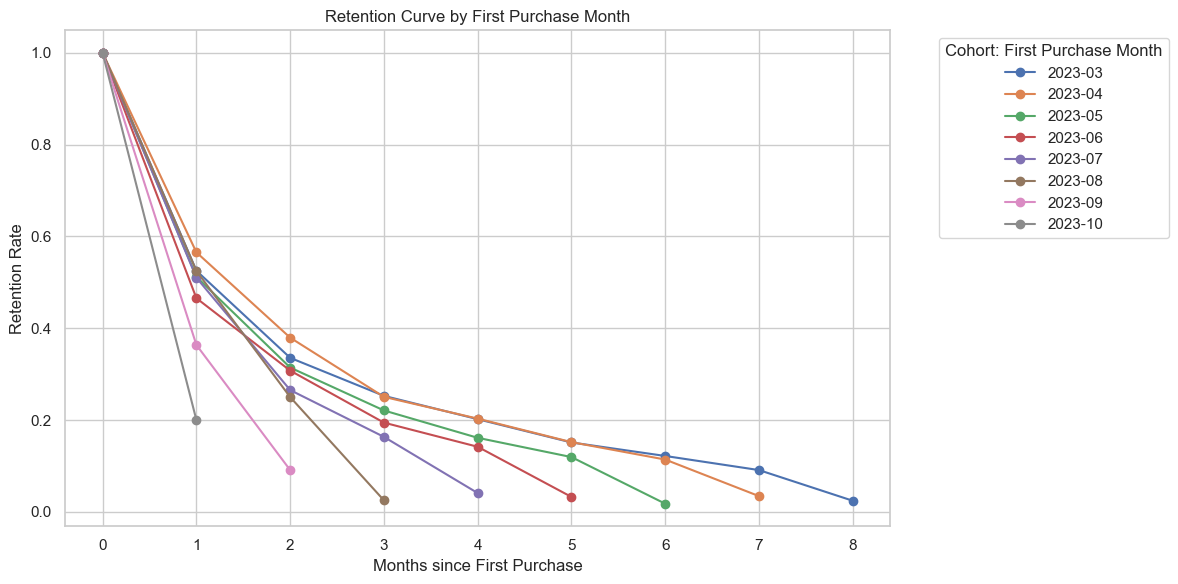

In [73]:
#Plot retention curves for each cohort

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

for month in retention_cohorts['first_purchase_month'].unique():
    cohort_data = retention_cohorts[retention_cohorts['first_purchase_month'] == month]
    plt.plot(cohort_data['cohort_lifetime'], cohort_data['retention'], marker='o', label=month)

plt.title('Retention Curve by First Purchase Month')
plt.xlabel('Months since First Purchase')
plt.ylabel('Retention Rate')
plt.legend(title='Cohort: First Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


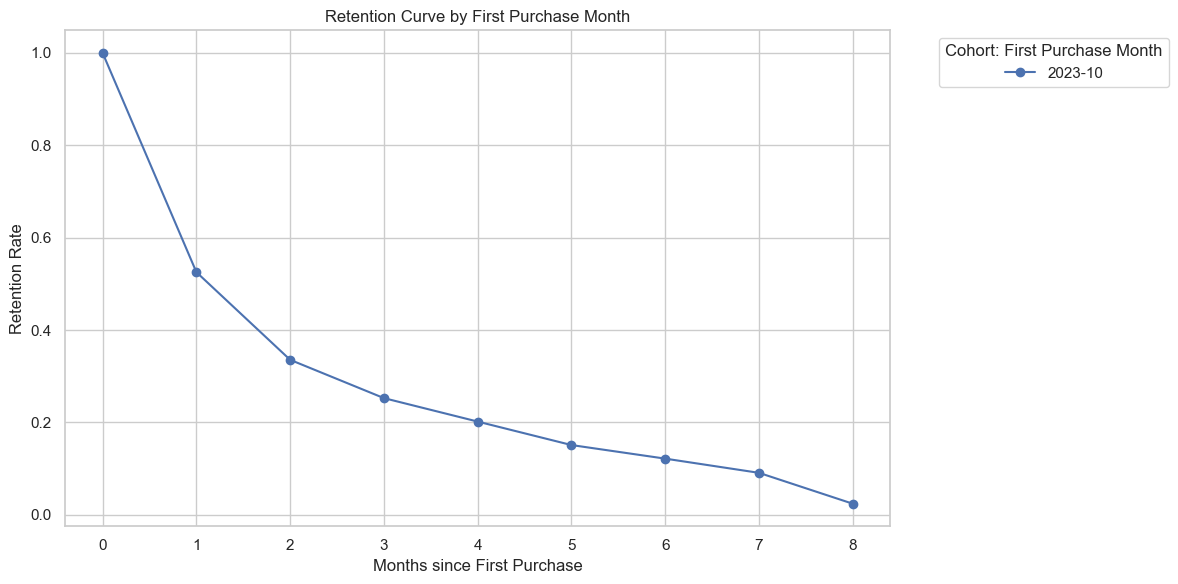

In [74]:
#Plot retention curve only for first cohort
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

cohort_data = retention_cohorts[retention_cohorts['first_purchase_month'] == '2023-03']
plt.plot(cohort_data['cohort_lifetime'], cohort_data['retention'], marker='o', label=month)

plt.title('Retention Curve by First Purchase Month')
plt.xlabel('Months since First Purchase')
plt.ylabel('Retention Rate')
plt.legend(title='Cohort: First Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


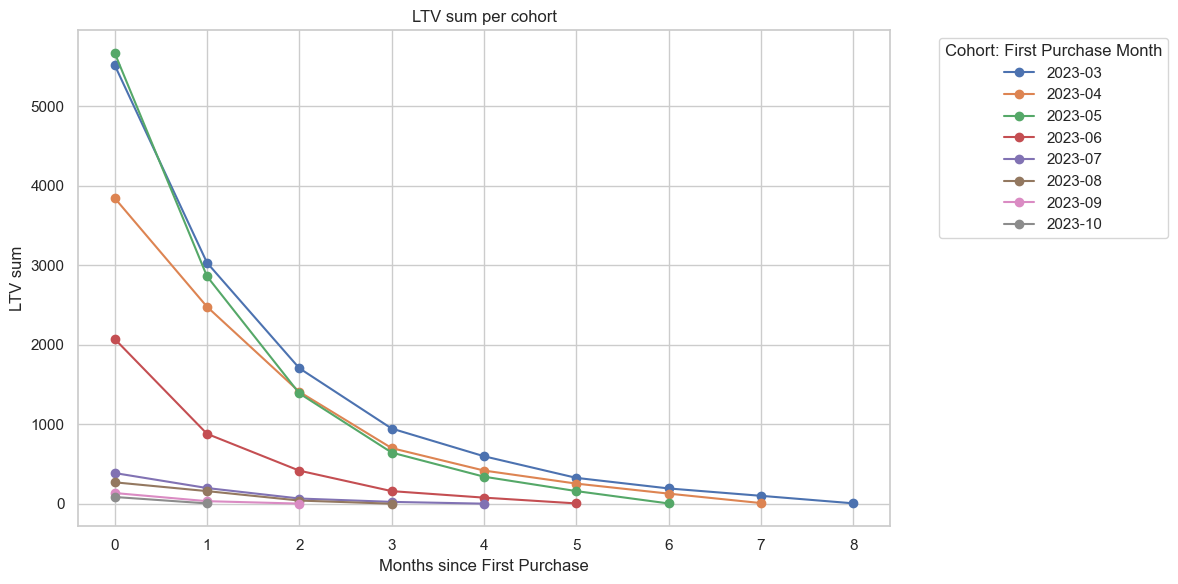

In [82]:
#Plot ltv curves for each cohort

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

for month in cohorts_combined['first_purchase_month'].unique():
    cohort_data = cohorts_combined[cohorts_combined['first_purchase_month'] == month]
    plt.plot(cohort_data['cohort_lifetime'], cohort_data['ltv'], marker='o', label=month)

plt.title('LTV sum per cohort')
plt.xlabel('Months since First Purchase')
plt.ylabel('LTV sum')
plt.legend(title='Cohort: First Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
